In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.integrate import odeint
from scipy.integrate import quad
import seaborn as sns

π=np.pi
G=4.4959e-15            #in units of M☉^-1 pc^3 yr^-2
c=0.3068                #in units of pc yr^-1
ρ_eq=3.1812e3           #in units of M☉ pc^-3 with ρ_eq=2.15368e-16 kg m^-3
pc=3.0857e16           # in meters
yr=3.154e7             # in units of seconds
t_m=13.78e9               #in units of yrs corresponding to t_0=13.78Gyr
t_eq=1.59246e12/yr       # in units of seconds

k=22.5707
σ_eq=0.005
ρ_m =4e19             #ρ_m=4e19 M☉ Gpc^-3


m_1=6   #in units of M☉
m_2=8   #in units of M☉

y_1=math.log(m_1)
y_2=math.log(m_2)
dy=(y_2-y_1)


y_list=np.zeros(10)

for i in range(len(y_list)):
    y_list[i]= (y_1+(i*dy))
    

M_1_list=np.zeros(len(y_list))
M_2_list=np.zeros(len(y_list))

for i, y in enumerate(y_list):
    M_1_list[i]=(math.ceil(math.exp(y)))
    M_2_list[i]=(math.ceil(math.exp(y)))
    

            
m_1_list=[int(M_1) for M_1 in M_1_list]
m_2_list=[int(M_2) for M_2 in M_2_list]

    
Δ_1_list=np.zeros(len(y_list))
Δ_2_list=np.zeros(len(y_list))

for i, y in enumerate(y_list):
    Δ_1_list[i] = math.exp(y + 0.5*dy)-math.exp(y - 0.5*dy)
    Δ_2_list[i] = math.exp(y + 0.5*dy)-math.exp(y - 0.5*dy) 
        

In [4]:
A=((ρ_eq**(4/3))*(G**3)*(k**7))/(c**5)


λ_0=0.001

def merger_rate(m_1,m_2,Δ_1,Δ_2,λ_0,t_m):
    
    def s(λ_0): # S_dec of the binary decouple.
        return ((0.03095*λ_0 + 0.3425)*λ_0)
    
    def t(λ_0): 
        return ((math.sqrt(3/(8*π*G*ρ_eq)))*(((2/3)*(s(λ_0)-2)*math.sqrt(s(λ_0)+1))+(4/3)))
    
    def ρ_bar(m):
        return ((ρ_eq/2)*(t_eq**(3/2))*((2*G*m)**(3/4))) 
    
    def M_halo(m,λ_0):
        return (((16*π)/3)*ρ_bar(m)*((2*G*m*(t(λ_0)**2))**(1/4)))
    
    def M(m,λ_0):
        return (m + M_halo(m,λ_0))
    
    def M_binary_initial(m_1,m_2, λ_0):
        return (m_1 + m_2 + M_halo(m_1,λ_0) + M_halo(m_2,λ_0))
     
    def factor(m_1,m_2,λ_0):
        return (M(m_1,λ_0) * M(m_2,λ_0))/(G*(m_1**2)*(m_2**2))
    
    def r_s(m): 
        return ((2*G*m)/(c**2)) 


    def r_ta(m,λ_0): 
        return ((2*G*m*(t(λ_0)**2))**(1/3))


    def E_b(m,λ_0): 
        return ((16*π*G*ρ_bar(m)* m *(((r_ta(m,λ_0))**(-1/4))-((r_s(m))**(-1/4))))-((128/3)*G*(π**2)*(ρ_bar(m)**2)*(((r_ta(m,λ_0))**(1/2))-((r_s(m))**(1/2)))))

    
    def f_(m):
        return f*P(m)
    
    def f_b(m_1,m_2):
        return  f_(m_1)+f_(m_2)
    
    def μ(m_1,m_2,Δ_1,Δ_2):
        return   (2 * m_1 * m_2 * f_b(m_1,m_2) * math.sqrt(Δ_1*Δ_2))/((m_1+m_2) * ((f_(m_2)*Δ_2 * m_1) + (f_(m_1)*Δ_1 * m_2)))

    
    def B(m_1,m_2,Δ_1,Δ_2):
        return (A**(1/7)) * ((M(m_1,λ_0) * M(m_2,λ_0) * t_m)**(1/7)) *  (M_binary_initial(m_1,m_2, λ_0)**(9/14)) *  ((m_1+m_2)**(-29/42)) * ((f_b(m_1,m_2))**(37/21))* ((f**2 + 1.2005*(σ_eq**2))**(-1/2)) * ((Δ_1*Δ_2)**(37/42))
    
    def D(m_1,m_2,Δ_1,Δ_2):
        return (B(m_1,m_2,Δ_1,Δ_2)**(21/37))/(f_b(m_1,m_2)*math.sqrt(Δ_1*Δ_2))  
    
    def γ_X(Y,m_1,m_2,Δ_1,Δ_2):      #eq.(12) in the notes.
        return ((((1 + 0.0583 * D(m_1,m_2,Δ_1,Δ_2) * (Y**(-21/37)))**(-1/14))/( 1 + 0.4440 * D(m_1,m_2,Δ_1,Δ_2) * (Y**(-21/37))))*Y)

    def PDF(m):
        return (P(m)/m)

    I = quad(PDF, 5, np.inf)  # Taking limits of the PBH mass from 5 M☉ to 100 M☉ instead of 
                               # 0 to infinity.
    
    n_T = f * ρ_eq * I[0]         #n_T=f*ρ_eq∫(P(m)/m)*dm 
   
    def x̄(m_1,m_2,Δ_1,Δ_2):
        return (((3*(m_1+m_2))/(8*π*ρ_eq*f_b(m_1,m_2)*math.sqrt(Δ_1*Δ_2)))**(1/3))
    
    Y=np.geomspace(1e-2,1e10,1000000) 
    
    def a_i(Y,m_1,m_2,Δ_1,Δ_2):
        return (0.0977 * D(m_1,m_2,Δ_1,Δ_2) * (Y**(-21/37)))  +  (0.0057 *  (D(m_1,m_2,Δ_1,Δ_2)**2) * (Y**(-42/37)))
    
    def A(Y,m_1,m_2,Δ_1,Δ_2):
        return  factor(m_1,m_2,λ_0) * ((G * M(m_1,λ_0) * M(m_2,λ_0) ) -  (2 * a_i(Y,m_1,m_2,Δ_1,Δ_2) * (E_b(m_1,λ_0)+ E_b(m_2,λ_0))))
    
    def integrand(Y,m_1,m_2,Δ_1,Δ_2):
        return (Y**(-58/37))  * A(Y,m_1,m_2,Δ_1,Δ_2) *  math.exp(-((4*π)/3)  * (x̄(m_1,m_2,Δ_1,Δ_2)**3) * n_T * ((Y/B(m_1,m_2,Δ_1,Δ_2))**(-21/37))) * ((γ_X(Y,m_1,m_2,Δ_1,Δ_2)**2)/ ((1 + (γ_X(Y,m_1,m_2,Δ_1,Δ_2)**2))**(3/2)))
    
   
    f2=np.vectorize(integrand)
    
    
    return (3/74) * (A**(3/37))  * ρ_m * (t_m** (-34/37))* (f**2) *  ((f**2 + 1.2005*(σ_eq**2))**(-21/74)) *  ((M(m_1,λ_0)*M(m_2,λ_0))**(3/37)) * (M_binary_initial(m_1,m_2,λ_0)**(27/74)) *  ((m_1+m_2)**(45/74)) * np.minimum((P(m_1)*Δ_1)/m_1, (P(m_2)*Δ_2)/m_2) * ((P(m_1)*Δ_1)/m_1 + (P(m_2)*Δ_2)/m_2)  * (np.trapz(f2(Y,m_1,m_2,Δ_1,Δ_2),Y)) 


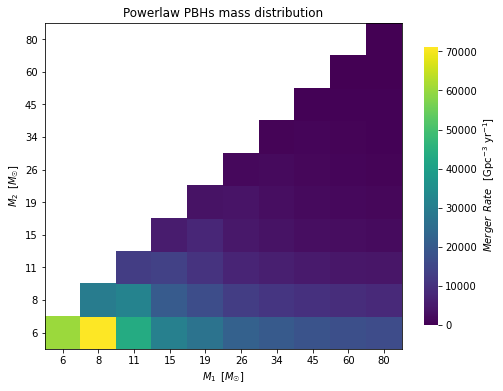

In [3]:
# Calculation of the 2D merger rate for Powerlaw PBH mass distribution. 
#The resolution of the PBHs masses m_1 is Δ_1 and of m_2 is Δ_2.


Merge = np.zeros((10, 10))



for i in range(10):
    for j in range(10):
        
        f_pbh = 4.3e-3
        f = 0.85*f_pbh
        
          
        def P(m): #Powerlaw PBH mass distribution
            α = 1.6
            M = 5     #in units of M☉
            return ((α-1)/M) * ((m/M)**(-α))

        if i==j:
            Merge[i,j] = 0.5*merger_rate(m_1_list[i], m_2_list[j], Δ_1_list[i], Δ_2_list[j],λ_0, t_m)
            
        else:
            Merge[i,j] = merger_rate(m_1_list[i], m_2_list[j], Δ_1_list[i], Δ_2_list[j],λ_0, t_m)   
    
        


mask = np.tril(Merge,k=-1)  #created an array of shape Merger_12 with all the elements in it being 0.
fig,ax= plt.subplots(figsize=(8, 6))  

ax = sns.heatmap(Merge, mask=mask,  cmap='viridis', cbar=True, 
                 cbar_kws={"shrink": 0.85,'label': ' $Merger\hspace{0.5}Rate \hspace{0.5}$ [Gpc$^{-3}$ yr$^{-1}$]'},
                 vmin=0)



ax.set_xticklabels(m_1_list)
ax.set_yticklabels(m_2_list,rotation = 360)


# make frame visible
for _, spine in ax.spines.items():
    spine.set_visible(True)

ax.invert_yaxis()
plt.xlabel('$M_{1}\hspace{0.5}[M_{☉}]$')
plt.ylabel('$M_{2}\hspace{0.5}[M_{☉}]$')
plt.title('Powerlaw PBHs mass distribution')
plt.savefig('PWR LAW.pdf')
plt.show()     

In [ ]:
# Calculation of the 2D merger rate for Log-Normal PBH mass Distribution. 
#The resolution of the PBHs masses m_1 is Δ_1 and of m_2 is Δ_2.


Merger = np.zeros((10, 10))


for i in range(10):
    for j in range(10):
        
        f_pbh = 3.7e-3
        f = 0.85*f_pbh 
        
        def P(m):               #Log-Normal PBH mass Distribution
            σ=0.6
            m_c=15               #in units of M☉
            return  (1/(σ*m*math.sqrt(2*π))) * math.exp(-((math.log(m/m_c))**2)/(2*(σ**2)))

        if i==j:
            Merger[i, j] = 0.5 * merger_rate(m_1_list[i], m_2_list[j], Δ_1_list[i], Δ_2_list[j], λ_0, t_m)
            
        else:
            Merger[i, j] = merger_rate(m_1_list[i], m_2_list[j], Δ_1_list[i], Δ_2_list[j], λ_0, t_m)
            



mask = np.tril(Merger,k=-1)  #created an array of shape Merger_12 with all the elements in it being 0.
fig,ax= plt.subplots(figsize=(8, 6))  

ax = sns.heatmap(Merger, mask=mask,  cmap='viridis', cbar=True,
                 cbar_kws={"shrink": 0.85,'label': ' $Merger\hspace{0.5}Rate \hspace{0.5}$ [Gpc$^{-3}$ yr$^{-1}$]'},
                 vmin=0)





ax.set_xticklabels(m_1_list)
ax.set_yticklabels(m_2_list,rotation = 360)


# make frame visible
for _, spine in ax.spines.items():
    spine.set_visible(True)


    
ax.invert_yaxis()
plt.xlabel('$M_{1}\hspace{0.5}[M_{☉}]$')
plt.ylabel('$M_{2}\hspace{0.5}[M_{☉}]$')
plt.title('Log-Normal PBH mass Distribution')
plt.savefig('LOGNORMAL.pdf')
plt.show()     